# Lab 8: Losses and Efficiency Analysis

#### Andrew Phillips

## Prelab: Preparing to Measure Efficiency and Losses

In this prelab, I started calculating the losses present in our lab hardware. These losses can be largely grouped into two categorie: conduction losses, which are resistive losses that are unavoidable when real components carry an electric current, and switching losses, which are largely caused by the semiconductor devices in our circuit changing operation regions and the parasitic capacitances present in the circuit constantly charging and discharging in the circuit. To start my investigation, I came up with a list of loss mechanisms I was aware of that I wanted to measure, broken into conduction and switching losses below:

(We are using clamp and high frequency snubber for this lab)
 
Conduction Losses:
- FET conduction losses (based on Rds on)
- Diode conduction losses
- Transformer conduction losses
- Shunt losses (minimal)
- Conduction losses related to snubber and clamp (predominant loss form, calculate average power from PLECS waveforms)

Switching Losses: 
- FET switching losses (From moving through the saturation region to the active region. Note on this: In DCM, we will only see loss at FET turn on)
- Diode switching losses (Note, turn on losses are small, but turn off is significant due to the reverse recovery effect. This is minimal in a Schottky, so not modelling)
- Switching losses from caps in circuit and clamp/snubber (minimal)
- Ringing loss

In [8]:
import csv
import pandas as pd

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

In [9]:
# Calculation block
from math import sqrt
import numpy as np

# Circuit parameters
# From worksheet
Vg = 18 # V
Vo = 10 # V
Pout = 20 # W
Fs = 50e3 # Hz
D = 0.35 # duty cycle
Rshunt = 0.05 # Ohms

Rcp = 22 # Ohms, clamp resistance
Rsb_f = 10 # Ohms, fast snubber resistance

# From previous lab
Vpk_s = 4.28/10 # V, in shunt waveform from clamp testing in Lab 7

# baseline values
zeta_b = 0.041 # zeta baseline
L_b = 0.89e-6 # leakage
C_b = 6.5e-12 # capacitance

# From datasheets
Rds = 0.034 # Ohms
Vf = 0.68 # Forward voltage of diode

t_fall = 170e-9 #s
Vin = 30.8 #V

# From PLECS, using fundamental frequency of 50kHz
Irms_c = 0.4396 # clamp RMS current
Irms_s = 0.0434 # snubber RMS current
# Irms_shunt = 2.2403 # shunt RMS current

# Calculate RMS current primary
Ipk = Vpk_s/Rshunt 
print("Ipk from clamp testing",Ipk)
Irms = sqrt(D/3)*Ipk
print("I_rms in A:",Irms)

# calculate transformer primary winding resistance
Rw = (2*zeta_b)/sqrt(C_b/L_b)
print("Primary winding resistance:",Rw)

# Conduction losses
FET_c = Rds*Irms**2
print("FET conduction losses:",FET_c)

D_c = Vf*Irms
print("Diode Conduction losses:",D_c)

# Tran_c = Rw*Irms_shunt**2
# print("Transformer conduction losses:",Tran_c)
# ^ This equation isn't useful because the transformer is only 
# causing conduction loss when it is ringing, which is only a
# very small amount of the waveform

Clamp_c = Irms_c**2*Rcp
print("Clamp conduction losses:",Clamp_c)

Snubber_c = Irms_s**2*Rsb_f
print("Snubber conduction losses:",Snubber_c)

Shunt_c = Irms**2*Rshunt
print("Shunt conduction losses:",Shunt_c)

# Switching losses
# FET switching losses: drain voltage * shunt current
# FET_s_list = np.multiply(l7_cl_drain,l7_cl_shunt)
# FET_s = sum(FET_s_list)

FET_s = 0.5*Vin*Ipk*t_fall*Fs # we only have turn off losses because we are running in DCM
print("FET switching losses:",FET_s)

# Diode switching losses:
# wait we use a schottky so what (Elvis said it should be minimal)

Ipk from clamp testing 8.56
I_rms in A: 2.9237966185538053
Primary winding resistance: 30.342557064802058
FET conduction losses: 0.2906519466666667
Diode Conduction losses: 1.9881817006165878
Clamp conduction losses: 4.25145952
Snubber conduction losses: 0.0188356
Shunt conduction losses: 0.4274293333333334
FET switching losses: 1.120504


Total Losses: 8.097062100616586


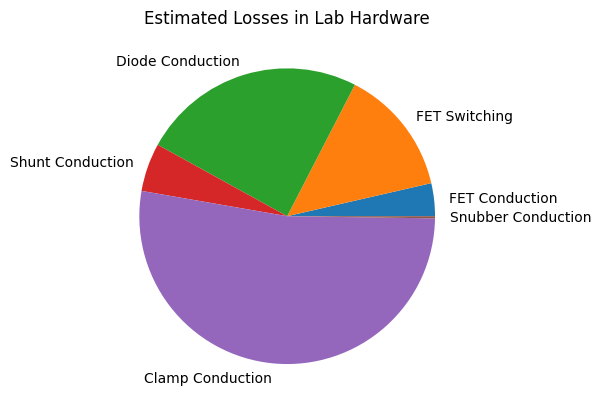

In [17]:
# Plot in pie chart
import matplotlib.pyplot as plt

losses = np.array([FET_c,FET_s,D_c,Shunt_c,Clamp_c,Snubber_c])
loss_total = np.sum([FET_c,FET_s,D_c,Shunt_c,Clamp_c,Snubber_c])
print("Total Losses:",loss_total)
labels = ["FET Conduction","FET Switching","Diode Conduction","Shunt Conduction","Clamp Conduction","Snubber Conduction"]
plt.pie(losses,labels=labels)
plt.title("Estimated Losses in Lab Hardware")
plt.show()

With these calculations, I am estimating a total loss of 8.09W, which matches closely with my collected data in this lab.

## Data Collection (Lab Questions 1-4)

To collect the data for this lab, we set up our lab hardware, populating it with the RCD clamp and high frequency RC snubber we designed in the previous lab. We first measured the efficiency of the hardware at its baseline operating point, where our hardware is operating at approximately 35% duty cycle. We then stepped down our input voltage by 1 V to achieve boundary conduction mode operation, which we could verify by the lack of low frequency ringing on the drain voltage waveform. We calculated the efficiencies and total power dissipated at both operating states. To get a better sense of some of the heat producing components in the system, we took pictures of our lab hardware during operation using an IR camera. The efficiencies and total power lost is calculated in the block below:

In [11]:
# Efficiency calc
# task 1:
Rload = 5 #Ohms

Vg = 18 #V
Vo = 10 #V
Iin = 1.66 #A
Iout = Vo/Rload #A

Pin = Vg*Iin
print("Task 1 Input power:",Pin)
Pout = Vo*Iout
print("Task 1 Output Power:",Pout)

Eff_1 = Pout/Pin
print("Task 1 Efficiency:",Eff_1)

Plost = Pin-Pout
print("Task 1 Total power lost:",Plost)

# task 2:

# BCM values:
# Input : 17.26V, 1.7A
# Output: 9.9V

Vg_2 = 17.26 #V
Vo_2 = 9.9 #V
Iin_2 = 1.7 #A
Iout_2 = Vo_2/Rload

Pin_2 = Vg_2*Iin_2
print("Task 2 Input power:",Pin_2)
Pout_2 = Vo_2*Iout_2
print("Task 2 Output Power:",Pout_2)

Eff_2 = Pout_2/Pin_2
print("Task 2 Efficiency:",Eff_2)

Plost_2 = Pin_2-Pout_2
print("Task 2 Total power lost:",Plost_2)

Task 1 Input power: 29.88
Task 1 Output Power: 20.0
Task 1 Efficiency: 0.6693440428380187
Task 1 Total power lost: 9.879999999999999
Task 2 Input power: 29.342000000000002
Task 2 Output Power: 19.602
Task 2 Efficiency: 0.6680526208165769
Task 2 Total power lost: 9.740000000000002


## Data Plotting

Text(0.5, 1.0, 'Baseline Shunt Voltage at 10.26V Output')

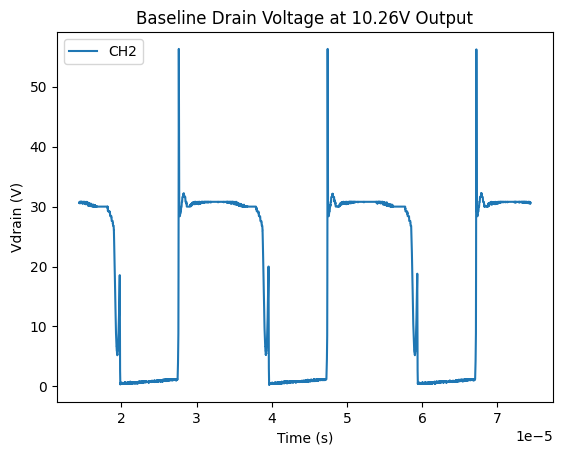

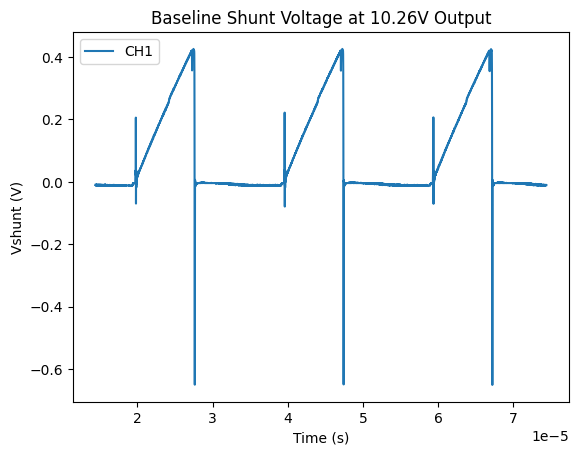

In [14]:
# baseline data
[baseline_data, baseline_data_t0, baseline_data_dT] = read_rigol_csv('data/baseline.csv')

# apply data filter
baseline_data['CH1'] = baseline_data['CH1'].rolling(10).mean()
baseline_data['CH2'] = baseline_data['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Baseline Drain Voltage at 10V Output")

# plot shunt voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Baseline Shunt Voltage at 10V Output")

Text(0.5, 1.0, 'BCM Shunt Voltage at 10V Output')

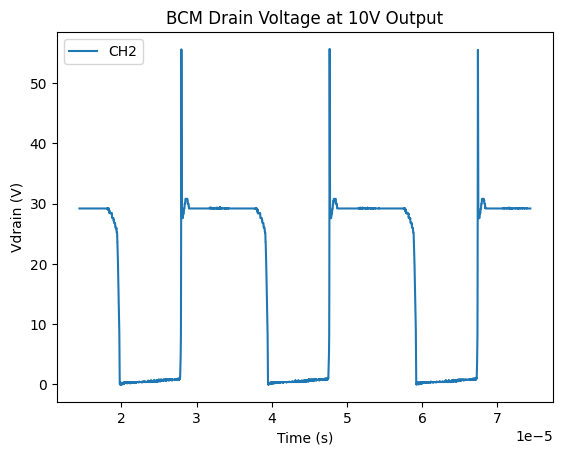

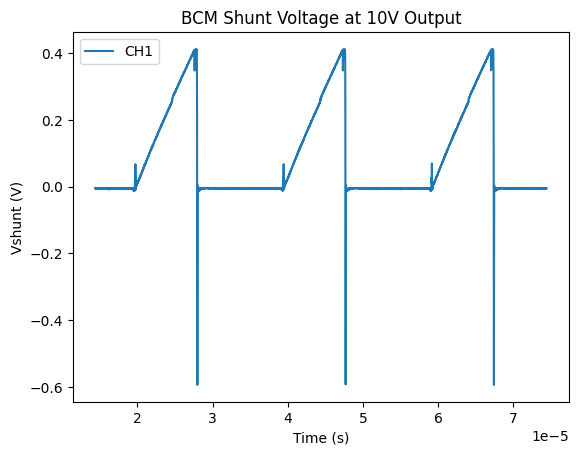

In [16]:
# bcm data
[bcm_data, bcm_data_t0, bcm_data_dT] = read_rigol_csv('data/bcm.csv')

# apply data filter
bcm_data['CH1'] = bcm_data['CH1'].rolling(10).mean()
bcm_data['CH2'] = bcm_data['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
bcm_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("BCM Drain Voltage at 10V Output")

# plot shunt voltage
fig, ax = plt.subplots()
bcm_data.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("BCM Shunt Voltage at 10V Output")

## Full Power Thermal Testing

Select photos highlight various heat producing components on the board are shown in the FLIR images below:

Board Overview:

![board_overview](images/board_overview.jpg)

Switching FET:

![fet](images/fet.jpg)

Flyback Diode:

![flyback_diode](images/flyback_diode.jpg)

Load Resistor:

![load_resistor](images/load_resistor.jpg)

Primary Shunt:

![shunt](images/shunt.jpg)

Secondary Shunt:

![sec_shunt](images/secondary_shunt.jpg)

Jong Ho (Note: not part of the circuit):

![jong_ho](images/jongho.jpg)

## Post Lab Analysis

7. Overall, I think I did a decent job accounting for a majority of the losses in the circuit in my prelab calculations, as I calculated a loss total of 8.09W compared to a measured loss total of 9.87W for our baseline measurements and 9.74W for our BCM measurements. I was initially surprised to see how inefficient our converter was (66.9% in baseline and 66.8% in BCM). It really showed me how much loss the RCD clamp we designed could introduce into the circuit with an overly large margin of safety. In the future, I would likely reduce this margin from 38V to something closer to the spec (maybe 50V?). Our high frequency snubber design could also be improved to significantly reduce losses in our circuit as well.

8. The FLIR temperature measurements also largely match my prelab calculations. Some of the hottest components I identified in the circuit was the primary side shunt resistor, the flyback diode, and the switching FET. Surprisingly, the clamp resistor did not appear as an especially high temperature component despite making up a majority of my calculated losses. Another high temperature component that I did not include in my prelab calculations was the secondary shunt resistor, which I did not realize was in our circuit until this lab. I have updated my losses pie chart to include this component below.

10. 

Shunt conduction losses: 0.2
Total Losses: 8.297062100616587


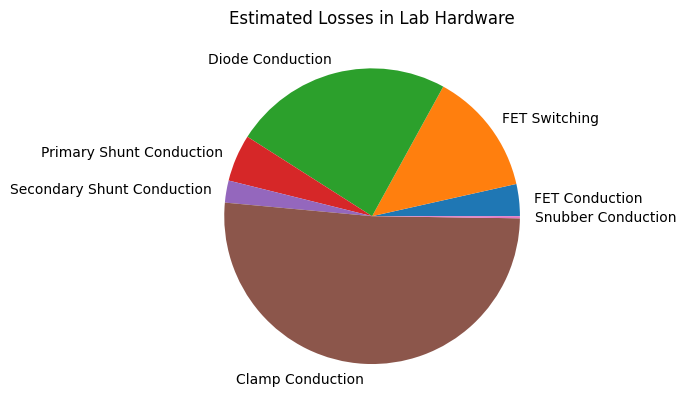

In [19]:
# calculate secondary shunt conduction loss
Shunt_2_c = Iout**2*Rshunt
print("Shunt conduction losses:",Shunt_2_c)

# update pie chart
losses = np.array([FET_c,FET_s,D_c,Shunt_c,Shunt_2_c,Clamp_c,Snubber_c])
loss_total = np.sum([FET_c,FET_s,D_c,Shunt_c,Shunt_2_c,Clamp_c,Snubber_c])
print("Total Losses:",loss_total)
labels = ["FET Conduction","FET Switching","Diode Conduction","Primary Shunt Conduction","Secondary Shunt Conduction","Clamp Conduction","Snubber Conduction"]
plt.pie(losses,labels=labels)
plt.title("Estimated Losses in Lab Hardware")
plt.show()

11. Unfortunately, we don't have a lot of data to see the total loss trends, as our baseline measurement was already very close to BCM operation. We do see a drop in total power loss of 0.14W, likely due to both the reduced slow ring and slightly lower input drain voltage.

12 and 13. As input voltage is reduced, the overall duty cycle of the converter would increase, as a higher percentage of the converter's input power has to be delivered to the converter's output (As the output load conditions are not changing but the input power is being reduced). This change in duty cycle would result in an increase in conduction losses on the primary side components like the FET, snubber, and clamp, while reducing the switching losses of the diode proportionally with the amount of time each side has to conduct. A decrease in the input voltage also likely reduces the switching time of the FET as it will not be as far into the saturation region when it exits the cut off region. This decreased switching time will reduce the switching losses of the circuit. These overall changes to the loss mechanisms of the circuit will result in improved efficency of the converter with a lower input voltage (closer to the desired output voltage).

14. One way to improve the efficiency of our converter is to reduce the safety margin of the RCD clamp. By increasing to clamp voltage, we can design to clamp to use a smaller resistor, which will significantly reduce both the conduction losses through the clamp and the conduction losses of the overall circuit. Another way we can improve the efficiency of our converter is to ensure the converter operates in BCM. BCM has several advantages over DCM, including a lower input voltage resulting in lower switching losses and an absence of the low frequency ring from the flyback diode, which will further reduce conduction losses.